# Standard modules

In [1]:
                            import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import pickle
from time import time
from datetime import datetime
import warnings
from IPython.display import Image

# Custom modules

In [2]:
import sys
sys.path.insert(1, '/home/mauricio/code/mcr/')
from mcr.util import size, to_csv_to_zip
from mcr.ml import fit_cache

# Data

In [3]:
model_dir = '/data/drivendata/models/2022/'
prediction_dir = '/data/drivendata/predictions/2022/'

df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
# sample to avoid bias in downstream cross-validation train-test split
df = df.sample(frac=1, random_state=1)
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
y = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
TEXT_FEATURES = ['Object_Description', 'Sub_Object_Description', 'Function_Description', 'Fund_Description',
                 'SubFund_Description', 'Program_Description', 'Location_Description', 'Facility_or_Department',
                 'Job_Title_Description', 'Position_Extra', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
# strip spaces and lower case of text features columns
# df[TEXT_FEATURES] = df[TEXT_FEATURES].apply(lambda x: x.str.strip().str.lower())
# holdout[TEXT_FEATURES] = holdout[TEXT_FEATURES].apply(lambda x: x.str.strip().str.lower())

# Model metric: multi-multi log loss

In [4]:
from sklearn.metrics import make_scorer
from mcr.ml import get_dummies_indices

from mcr.ml.metrics import multi_multi_log_loss, log_loss_report
cci = get_dummies_indices(df[LABELS])
multi_multi_log_loss_scorer = make_scorer(multi_multi_log_loss, greater_is_better=False, needs_proba=True, class_column_indices=cci)
multi_multi_log_loss_scorer

make_scorer(multi_multi_log_loss, greater_is_better=False, needs_proba=True, class_column_indices=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], [76, 77, 78], [79, 80, 81], [82, 83, 84, 85, 86], [87, 88, 89, 90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100, 101, 102, 103]])

# Candidate classifiers

[DummyClassifier(*, strategy='prior', random_state=None, constant=None)](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier)

    strategy={“most_frequent”, “prior”, “stratified”, “uniform”, “constant”}
    
[LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression)

    penalty={‘l1’, ‘l2’, ‘elasticnet’, ‘none’}
    tol=1e-4
    C=1.0
    fit_intercept=True
    class_weight=dict or ‘balanced’, default=None
    random_state=None #Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
    solver={‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
        For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
        For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
        ‘liblinear’ is limited to one-versus-rest schemes.
        The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
            ‘newton-cg’ - [‘l2’, ‘none’]
            ‘lbfgs’ - [‘l2’, ‘none’]
            ‘liblinear’ - [‘l1’, ‘l2’]
            ‘sag’ - [‘l2’, ‘none’]
            ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]
    max_iter=100
    multi_class{‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
        If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss
        minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.
        ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or
        if solver=’liblinear’, and otherwise selects ‘multinomial’.
    warm_start=False
        When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the
        previous solution. Useless for liblinear solver.
    n_jobs=None
    l1_ratio=None
        The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1.

[OneVsRestClassifier(estimator, *, n_jobs=None, verbose=0)](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn-multiclass-onevsrestclassifier)

    n_jobs=None
        
[RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)
  
    n_estimators=100
    criterion={“gini”, “entropy”, “log_loss”}, default=”gini”
    max_depth=None
        The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
        less than min_samples_split samples.
    min_samples_split=2
        The minimum number of samples required to split an internal node:
            If int, then consider min_samples_split as the minimum number.
            If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of
            samples for each split.
    min_samples_leaf=1
        The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it
        leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of
        smoothing the model, especially in regression.
            If int, then consider min_samples_leaf as the minimum number.
            If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of
            samplesfor each node.
    max_features={“sqrt”, “log2”, None}, int or float, default=”sqrt”
        The number of features to consider when looking for the best split:
            If int, then consider max_features features at each split.
            If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at
            each split.
            If “auto”, then max_features=sqrt(n_features).
            If “sqrt”, then max_features=sqrt(n_features).
            If “log2”, then max_features=log2(n_features).
            If None, then max_features=n_features.
    bootstrap=True
        Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
    n_jobs=None
    random_state=None (means 1),int, RandomState instance or None, default=None
        Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the
        sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
    warm_start=False
        When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise,
        just fit a whole new forest.
    class_weight={“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have
        weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
        Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict.
        For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1},
        {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].
        The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
        in the input data as n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample
        for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is
        specified.
        
[GaussianNB(*, priors=None, var_smoothing=1e-09)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn-naive-bayes-gaussiannb)

[MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn-naive-bayes-multinomialnb)

[ComplementNB(*, alpha=1.0, fit_prior=True, class_prior=None, norm=False)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn-naive-bayes-complementnb)

[SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc)

[KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier)

[XGBClassifier(*, objective='binar':logistic', use_label_encoder=False, **kwargs)](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)



In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Baseline pipeline

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, MissingIndicator #, KNNImputer, IterativeImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.base import clone

In [7]:
from mcr.ml.preprocessing import disambiguate, combine_text_columns, sign_indicator
from mcr.nlp import SentenceTokenizer, WordTokenizer, WORD_TOKENIZER_REGEX, SKLEARN_WORD_TOKENIZER_REGEX

In [8]:
# get_numeric_data = FunctionTransformer(disambiguate, validate=False, kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})
def select_dtype_number(df, cols=NUMERIC_FEATURES):
    return df.select_dtypes('number') if cols is None else df[cols]
get_numeric_data = FunctionTransformer(select_dtype_number, validate=False)
get_text_data = FunctionTransformer(combine_text_columns, validate=False, kw_args = {'to_drop': LABELS, 'sep':' '})

In [9]:
numeric_impute_missing_discrete_quantile_inclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False))
    ], verbose=False, n_jobs=None))
], verbose=False)

In [10]:
text_pl = Pipeline([
    ('text_selector', get_text_data),
    ('vectorizer', HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX
                                     #, dtype='uint8'
                                    )),
    ('reducer', SelectKBest(score_func=chi2))
], verbose=False)

In [11]:
baseline_pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', clone(numeric_impute_missing_discrete_quantile_inclusive_sign_pl)),
        ('text_features' , clone(text_pl))
    ], verbose=False, n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    # ('scaler', StandardScaler(with_mean=False)), # slower, worse and sometimes take indefinite time
    ('scaler', MaxAbsScaler()), # faster and better for the interactions of numeric and discretized features (17) plus (k) token counts    
    ('classifier', OneVsRestClassifier(LogisticRegression(random_state=1, solver='liblinear', max_iter=600)))
], verbose=False
)
baseline_pl

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('numeric_selector',
                                                                  FunctionTransformer(func=<function select_dtype_number at 0x7f0cc49b64c0>)),
                                                                 ('union',
                                                                  FeatureUnion(transformer_list=[('imputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                fill_value=0,
                                                                                                                strategy='constant')),
                                                                                                 ('discretizer',
                                                                                                  Pipeline(steps=[('imputer',
                                                                                                                   Simp...
                                                                  HashingVectorizer(alternate_sign=False,
                                                                                    norm=None,
                                                                                    token_pattern='(?u)\\b\\w+\\b')),
                                                                 ('reducer',
                                                                  SelectKBest(score_func=<function chi2 at 0x7f0ce0e6eee0>))]))])),
                ('interactor',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=600,
                                                                  random_state=1,
                                                                  solver='liblinear')))])

# Learning and validation curves

In [12]:
from mcr.ml.model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split
from mcr.ml.model_selection.learning_curve import plot_learning_curve, plot_multi_learning_curves
from mcr.ml.model_selection.validation_curve import plot_validation_curve
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from mcr.util import max_interactions

## `k` parameter space

Finding the best endpoint criteria for the `k` parameter space.

In [13]:
def k_space(start=1, stop=None, num=5, endpoint=True):
    if start > stop:
        raise ValueError(f'start {start} greater than stop {stop}')
    start = min(start, stop)
    num = min(num, stop)
    return np.logspace(start=np.log10(start), stop=np.log10(stop), num=num, endpoint=endpoint).round().astype('int').tolist()

### unigram vocabulary size

Limiting $k$ to the unigram vocabulary size, starting from its square root.

In [14]:
from mcr.nlp import ngram_vocabulary_size
# pre-fetch vocabulary_size
# vocabulary_size = ngram_vocabulary_size(df[TEXT_FEATURES])
vocabulary_size=3758
k_space(start=np.sqrt(vocabulary_size), stop=vocabulary_size)

[61, 172, 480, 1343, 3758]

### `n_features`

Limiting $k$ so its interactions won't exceed `HashingVectorizer's n_features` $2^{20}$ (1,048,576), considering the preexisting $j=17$ numeric features.

In [15]:
j = 17; n_features = 2**20
k_space(start=np.sqrt(max_interactions(n_features, j)), stop=max_interactions(n_features, j))

[38, 94, 233, 577, 1430]

## Estimators

The learning curves help comparing algorithms for bias-variance behavior, choosing model parameters during design, adjusting optimization to improve convergence and determining the amount of data used for training.

In this pipeline, the amount of data is determined not only by the sample size, but also by:
* the feature generation step `HashingVectorizer` with its parameter `ngram_range`.
* the feature selection step `SelectKBest(chi2)` with its parameter `k`.
* the feature generation step `PolynomialFeatures` with its parameters fixed.

Initially, it's picked main classification algorithms that support specific characteristics of the pipeline:
* Sparse data produced by the `HashingVectorizer` 
* Negative numbers present in the numeric features `Total`and `FTE`.

Because of this characteristics, alghorithms such as Naive Bayes can't be used:
* `GaussianNB` requires dense data
* `MultinomialNB` requires positive numbers.

Other alghorithms were much slow hence it's limited to `LogisticRegression`.  This limitation is expected to be removed in a future version.

The train sizes is a sligthly variation of the [default](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) `np.linspace(0.1, 1.0, 5)` to keep evenly spaced intervals.

In [16]:
classifiers = [OneVsRestClassifier(LogisticRegression(random_state=1, solver='liblinear', max_iter=600)),
               # OneVsRestClassifier(sklearn.linear_model.SGDClassifier(loss='log_loss')),
               # OneVsRestClassifier(sklearn.linear_model.SGDClassifier(loss='hinge')),
               # OneVsRestClassifier(DummyClassifier(strategy='uniform', random_state=1), n_jobs=None, verbose=0)
               # OneVsRestClassifier(SVC(probability=True)),
               # OneVsRestClassifier(XGBClassifier()),
               # OneVsRestClassifier(RandomForestClassifier()),
               # OneVsRestClassifier(KNeighborsClassifier())
              ]
for c in classifiers:
    print(' '.join(repr(c).split()), end='\n')

OneVsRestClassifier(estimator=LogisticRegression(max_iter=600, random_state=1, solver='liblinear'))


# Parameter grid

* tokenizer: default (None) or SentenceTokenizer
* sep: ' ' for default tokenizer or '. ' for SentenceTokenizer
* token_pattern: Regex '\\\w+' or '\\\w\\\w+' for default tokenizer or None for SentenceTokenizer
* ngram_range: (1,3) for default tokenizer and (1,1) for SentenceTokenizer
* k parameter space for default tokenizer: for each ngram_range and token_pattern
* k parameter space for SentenceTokenizer: for each ngram_range
* for each classifier

In [17]:
def build_parameter_grid(k=[1], kw_args={}):
    param_grid = \
    [
        # sklearn tokenizer ngram_range (1,1) stopwords
        {
            #'union__numeric_features__union__imputer__add_indicator': [True, False],
            #'union__text_features__text_selector__kw_args': [{'sep': ' '}],
            #'union__text_features__vectorizer__tokenizer': [None],
            # 'union__text_features__vectorizer__token_pattern': [WORD_TOKENIZER_REGEX,
            #                                                     #SKLEARN_WORD_TOKENIZER_REGEX                                                                
            #                                                    ],
            #'union__text_features__vectorizer__ngram_range': [(1,1)],
            # 'union__text_features__vectorizer__stop_words': [None,
            #                                                  #'english'
            #                                                 ],
            'union__text_features__reducer__k': k,
            #'interactor': [PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), 'passthrough'],
            #'scaler': [MaxAbsScaler(), StandardScaler(with_mean=False)],
            'classifier': classifiers,
            **kw_args
        },
        
#         # nltk sentence tokenizer
#         {
#             #'union__numeric_features__imputer__add_indicator': [True, False],
#             'union__text_features__text_selector__kw_args': [{'sep': '. '}],
#             'union__text_features__vectorizer__tokenizer': [SentenceTokenizer().tokenize],
#             'union__text_features__vectorizer__token_pattern': [None],
#             #'union__text_features__vectorizer__ngram_range': [(1,1)],
#             'union__text_features__reducer__k': k,
#             #'interactor': [PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), 'passthrough'],
#             #'scaler': [MaxAbsScaler(), StandardScaler(with_mean=False)],
#             'classifier': classifiers,
#         },
        
#         # nltk tokenizer ngram_range (1,1) stopwords
#         {
#             #'union__numeric_features__imputer__add_indicator': [True, False],
#             'union__text_features__text_selector__kw_args': [{'sep': '. '}],
#             'union__text_features__vectorizer__tokenizer': [WordTokenizer(pattern=WORD_TOKENIZER_REGEX).tokenize,
#                                                             WordTokenizer(pattern=SKLEARN_WORD_TOKENIZER_REGEX).tokenize
#                                                            ],
#             'union__text_features__vectorizer__token_pattern': [None],
#             #'union__text_features__vectorizer__ngram_range': [(1, 1)],
#             'union__text_features__vectorizer__stop_words': ['english',
#                                                              None
#                                                             ],
#             'union__text_features__reducer__k': k,
#             #'interactor': [PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), 'passthrough'],
#             #'scaler': [MaxAbsScaler(), StandardScaler(with_mean=False)],
#             'classifier': classifiers,
#         },
        
#         # nltk tokenizer ngram_range (2,7)
#         {
#             #'union__numeric_features__imputer__add_indicator': [True, False],
#             'union__text_features__text_selector__kw_args': [{'sep': '. '}],
#             'union__text_features__vectorizer__tokenizer': [WordTokenizer(pattern=WORD_TOKENIZER_REGEX).tokenize,
#                                                             WordTokenizer(pattern=SKLEARN_WORD_TOKENIZER_REGEX).tokenize                                                            
#                                                            ],
#             'union__text_features__vectorizer__token_pattern': [None],
#             'union__text_features__vectorizer__ngram_range': [(1, n) for n in range(2, 8)],
#             'union__text_features__reducer__k': k,
#             #'interactor': [PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), 'passthrough'],
#             #'scaler': [MaxAbsScaler(), StandardScaler(with_mean=False)],
#             'classifier': classifiers,
#         },
        
    ]
    return ParameterGrid(param_grid)

# 100% data learning curves

In [18]:
# 0.2 because 0.1 raises UserWarning: Label not 9 is present in all training examples.
train_sizes = np.linspace(0.2, 1, 5)
train_sizes

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [19]:
print('Observations   :', df.shape[0])
print('Train sizes    :', (df.shape[0] * train_sizes * .8).astype('int'))
print('Train percent  :', (df.shape[0] * train_sizes * .8).astype('int') / df.shape[0])
print('Test sizes     :', (df.shape[0] - (df.shape[0] * train_sizes * .8).astype('int')))

Observations   : 400277
Train sizes    : [ 64044 128088 192132 256177 320221]
Train percent  : [0.1599992 0.3199984 0.4799976 0.6399993 0.7999985]
Test sizes     : [336233 272189 208145 144100  80056]


In [20]:
# parameter_grid = build_parameter_grid(
#     k=[265, 382, 472, 548, 615, 657, 731, 782, 831, 877],
#     kw_args={
#         #'union__numeric_features__union__discretizer__imputed_discretizer__n_bins': [[2,5]],
#         #'union__numeric_features__union__discretizer': [None],
#         #'classifier__estimator__C': np.logspace(np.log10(0.1), np.log10(10), 5)
#     }
# )
# print('Number of plots:', len(list(parameter_grid)))
# plot_multi_learning_curves(baseline_pl, df[FEATURES], y, parameter_grid, scoring=multi_multi_log_loss_scorer, train_sizes=train_sizes, n_jobs=14)
# k=877 mmll=0.0539
# Last executed at 2022-11-26 00:30 in 2d

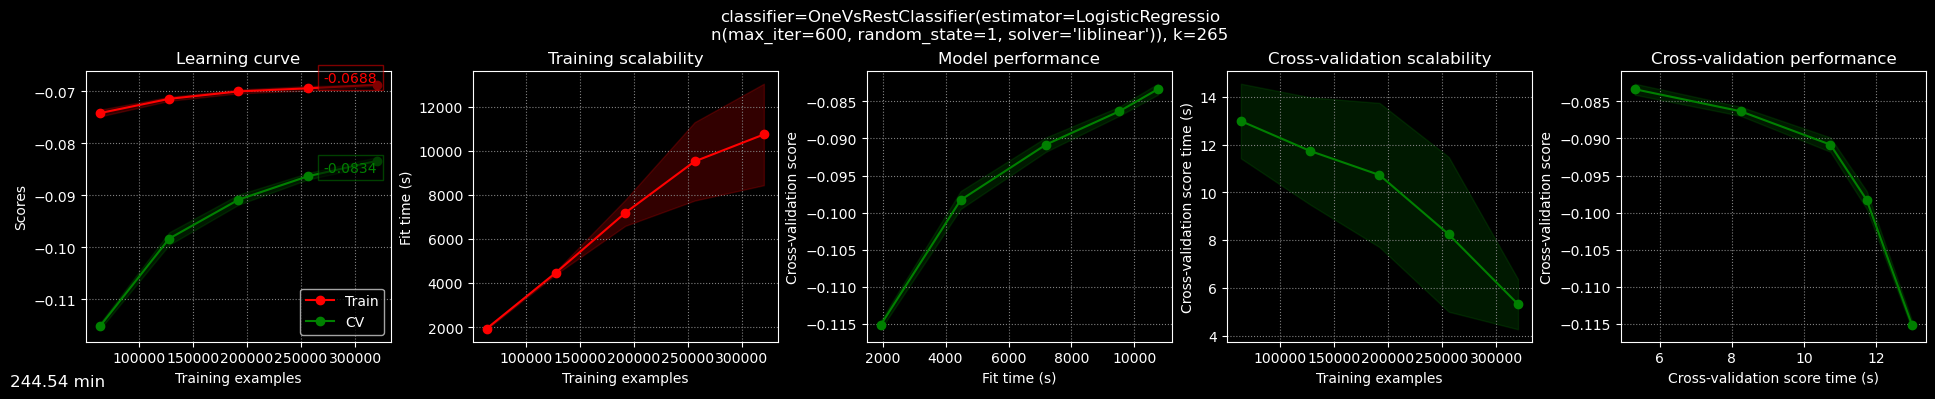

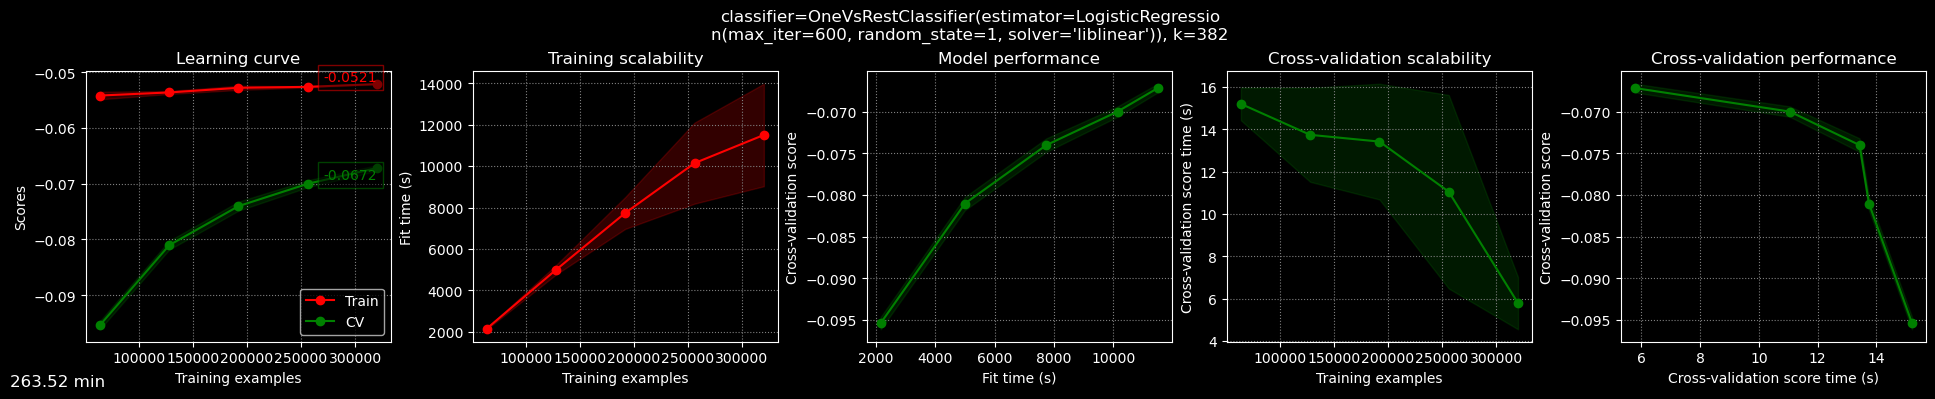

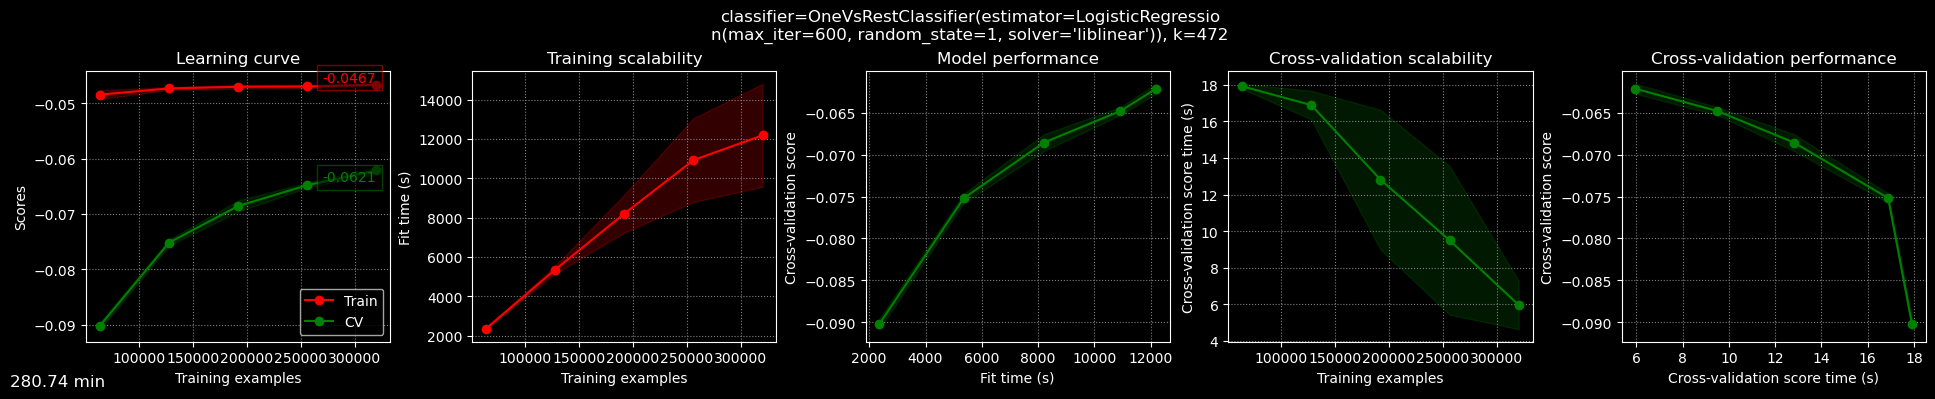

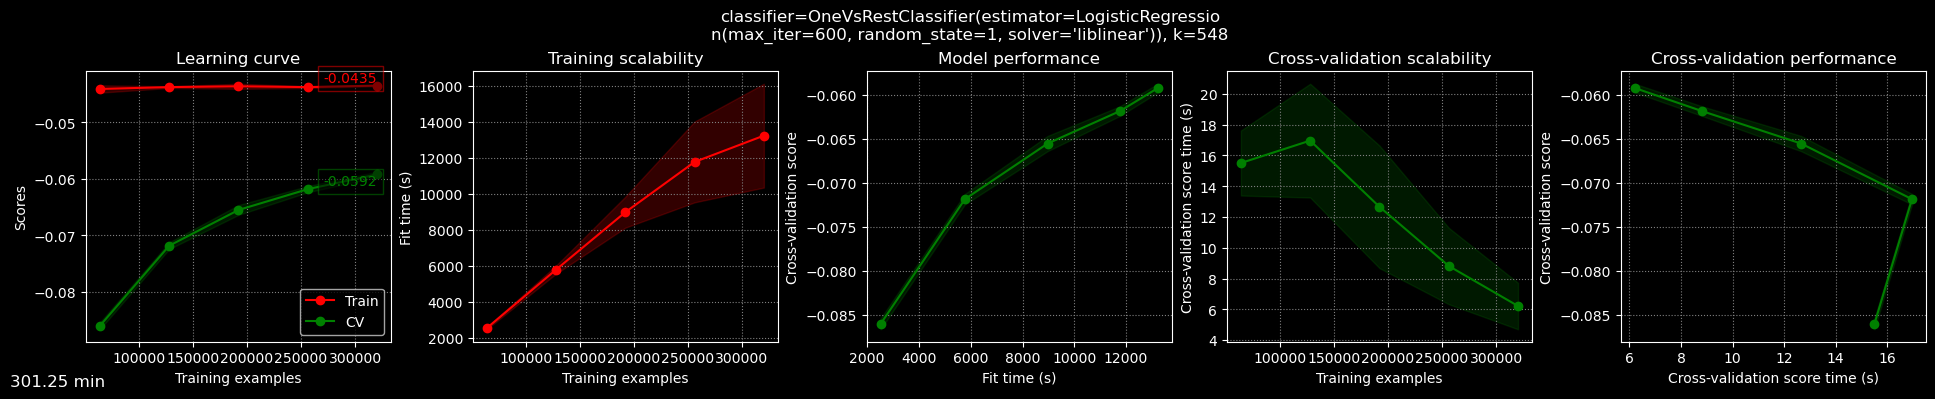

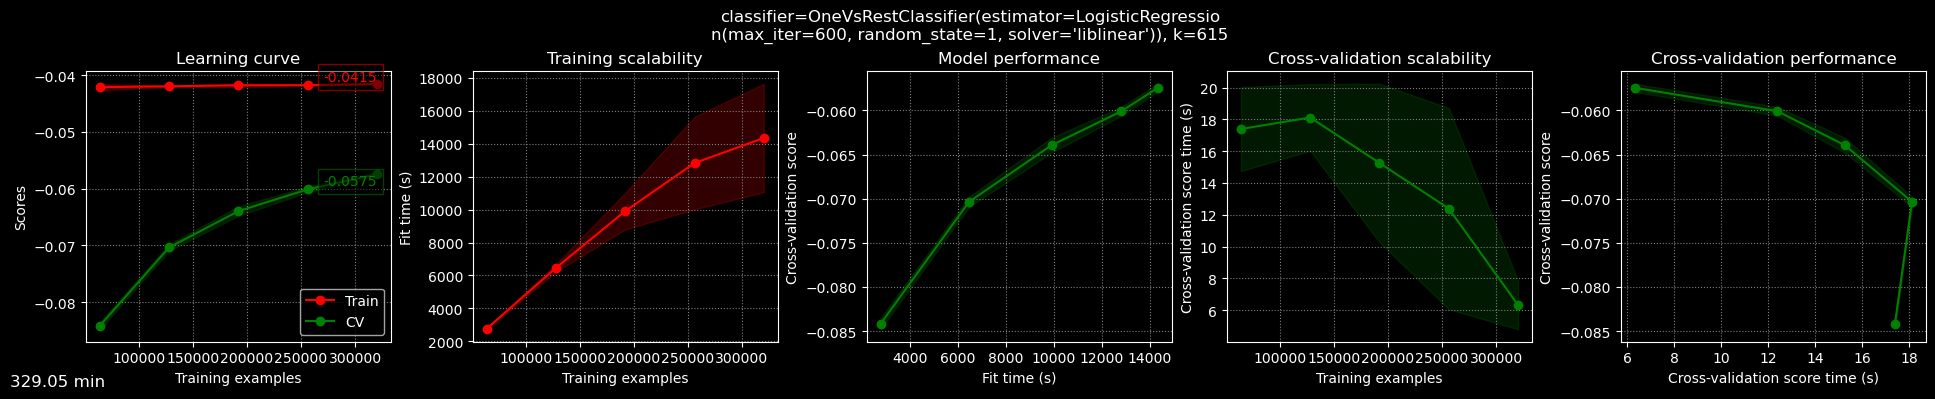

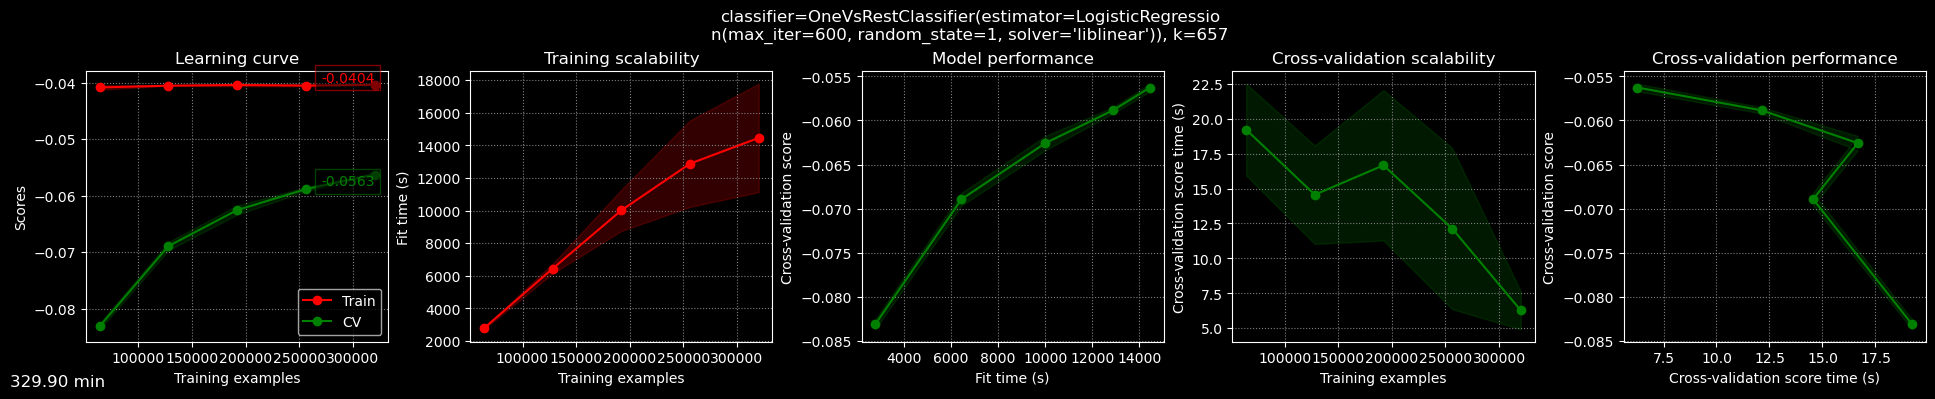

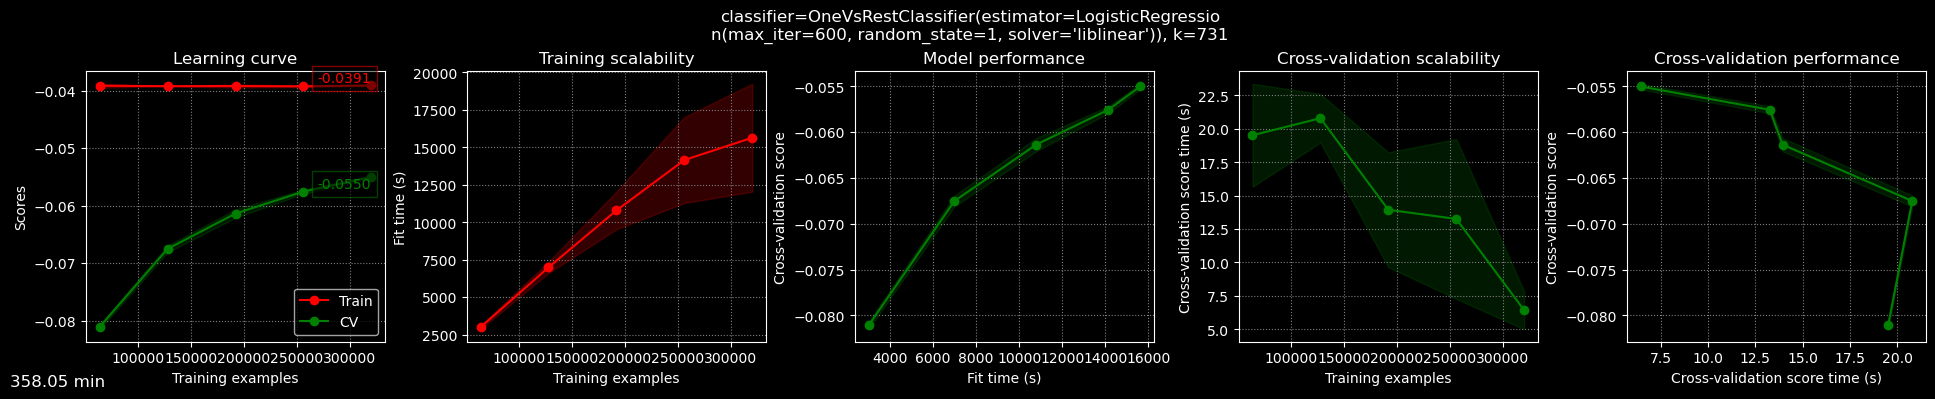

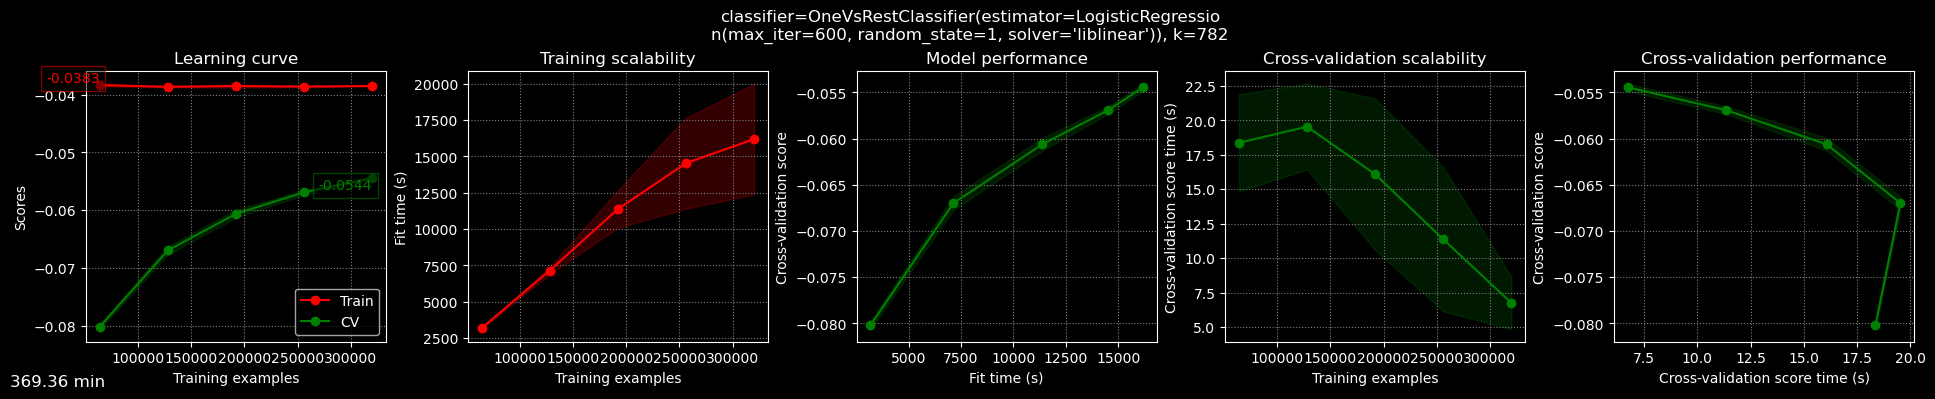

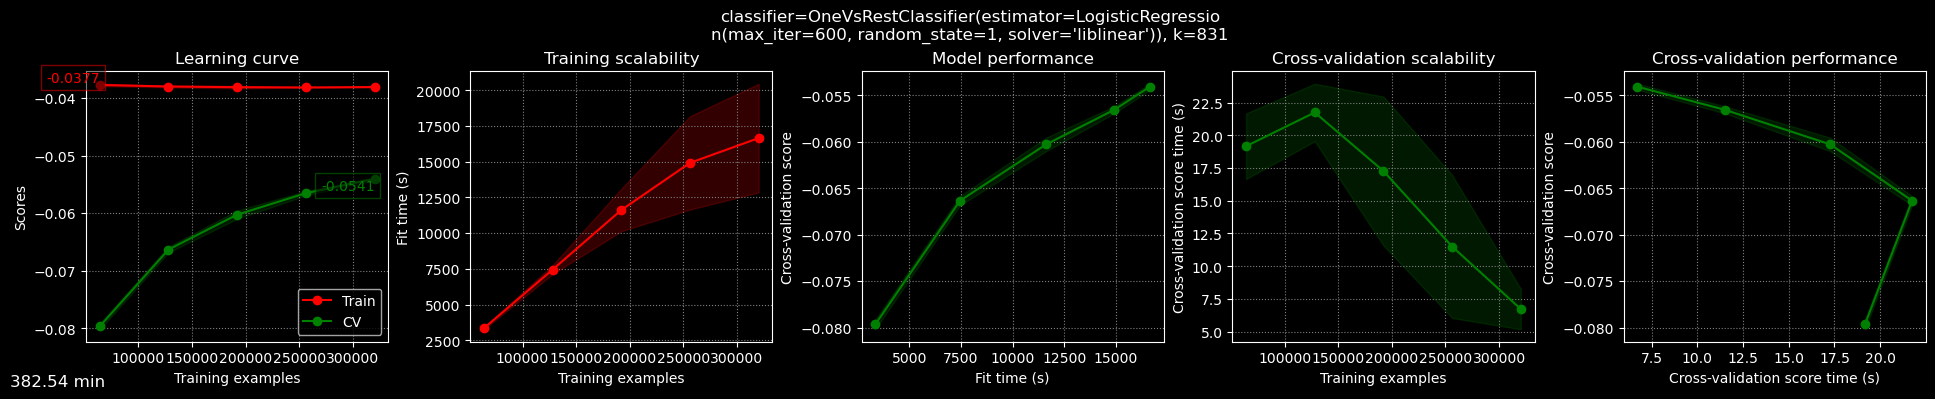

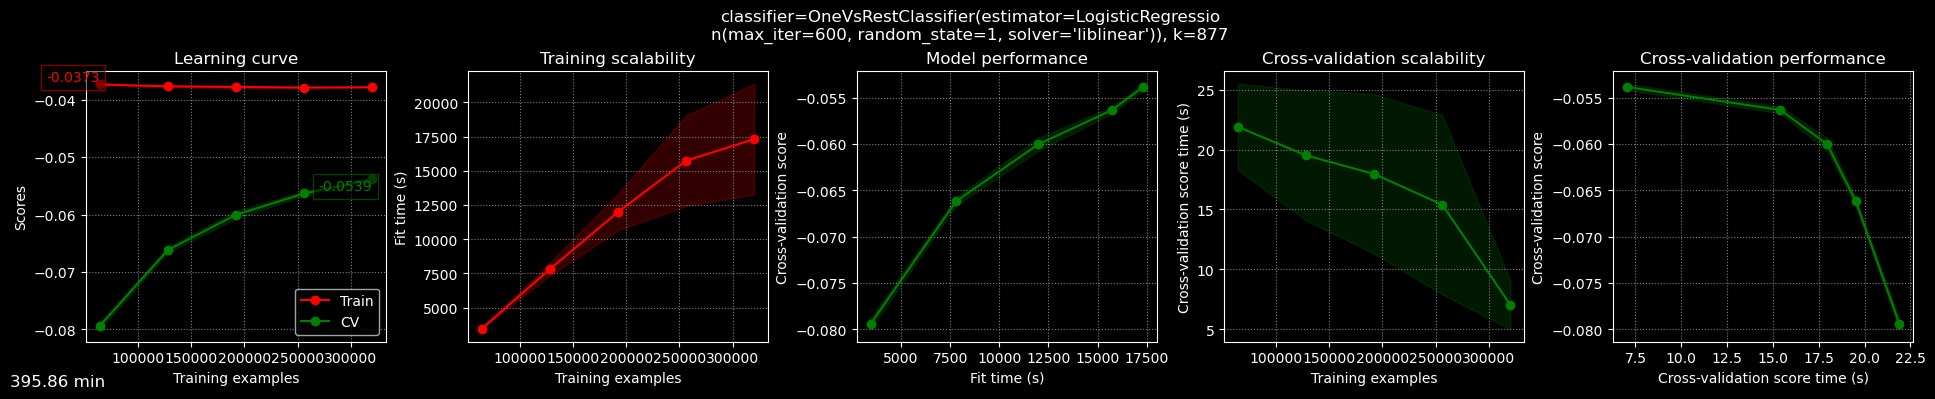

In [21]:
for x in range(1,11):
    display(Image(f'learning-curve-{x}.png'))

## Regularization validation curve

In [22]:
# print(f'Training: {df.shape[0]} (min_count: {y.sum().min()})')
# k = 877
# pl=clone(baseline_pl)
# pl.set_params(union__text_features__reducer__k = k)
# param_name='classifier__estimator__C'
# param_range = np.logspace(np.log10(0.1), np.log10(10), 5)
# param_label = 'C'
# plot_validation_curve(pl, df[FEATURES], y, param_name, param_range, param_label, scoring=multi_multi_log_loss_scorer, n_jobs=14)
# plt.show()
# C = 3.1622776601683795

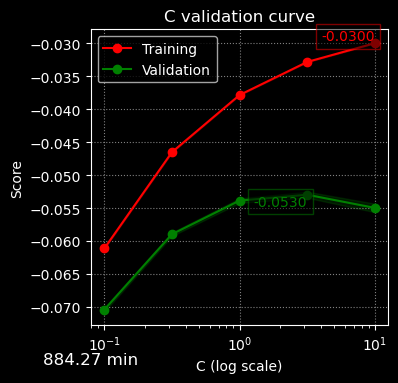

In [33]:
Image('400277-k877-validation-curve.png')

## Fit, score and predict for C = 3.1622776601683795

In [25]:
C = 3.1622776601683795
k = 877
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{df.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, df[FEATURES], y, model_dir, modelname)

Loading cache 400277-k877-logistic-regression-C3.1622776601683795 ... done: 0.0 minutes


```
Last executed at 2022-11-26 20:00:42 in 58m 13.86s

Fitting started on 2022-11-26T19:02
Done: 58.2 minutes
Saving cache 400277-k877-logistic-regression-C3.1622776601683795 ... Done: 0.0 minutes

Drivendata: 0.4917
```

In [26]:
log_loss_report(pl, df[FEATURES], y, LABELS, cci, part='Training')
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.9579191409948611
Training log loss         : 0.03316148929425484
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


## Fit, score and predict for C = 0.31622776601683794

In [44]:
C = 0.31622776601683794
k = 877
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{df.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, df[FEATURES], y, model_dir, modelname)

Fitting started on 2022-11-30T14:22
Done: 28.5 minutes
Saving cache 400277-k877-logistic-regression-C0.31622776601683794 ... Done: 0.0 minutes


```

Drivendata: ?
```

In [45]:
log_loss_report(pl, df[FEATURES], y, LABELS, cci, part='Training')
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.9429744901655603
Training log loss         : 0.045738723398224664
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


## Fit, score and predict for C = 0.1

In [42]:
C = 0.1
k = 877
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{df.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, df[FEATURES], y, model_dir, modelname)

Fitting started on 2022-11-30T13:56
Done: 21.8 minutes
Saving cache 400277-k877-logistic-regression-C0.1 ... Done: 0.0 minutes


```


Drivendata: ?
```

In [43]:
log_loss_report(pl, df[FEATURES], y, LABELS, cci, part='Training')
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.9257364275239397
Training log loss         : 0.05904326746744738
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


# 70% data

In [28]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], y, size=0.3, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
print(f'Training: {X_train.shape[0]} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()})')

Training: 280194 (min_count: 22), testing: 120083 (min_count: 7)


## Regularization validation curve

In [29]:
np.logspace(np.log10(0.1), np.log10(10), 5).tolist()

[0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0]

In [35]:
# k = 731
# pl=clone(baseline_pl)
# pl.set_params(union__text_features__reducer__k = k)
# param_name='classifier__estimator__C'
# param_range = np.logspace(np.log10(0.1), np.log10(10), 5)
# param_label = 'C'
# plot_validation_curve(pl, X_train[FEATURES], y_train, param_name, param_range, param_label, scoring=multi_multi_log_loss_scorer, n_jobs=14)
# plt.show()
# # C = 3.1622776601683795

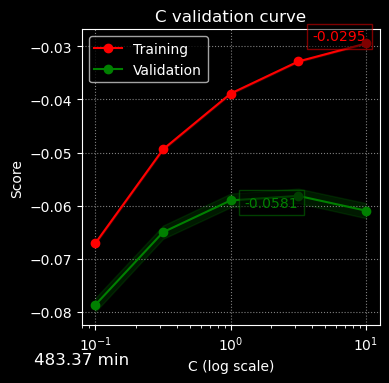

In [34]:
Image('280194-k731-validation-curve.png')

## Fit, score and predict for C = 3.1622776601683795

In [36]:
C = 3.1622776601683795
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{X_train.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, X_train, y_train, model_dir, modelname)

Loading cache 280194-k731-logistic-regression-C3.1622776601683795 ... done: 0.0 minutes


```
Last executed at 2022-11-30 11:39:37 in 30m 39.95s

Fitting started on 2022-11-30T11:08
Done: 30.7 minutes
Saving cache 280194-k731-logistic-regression-C3.1622776601683795 ... Done: 0.0 minutes

Drivendata: 0.4740
```

In [37]:
log_loss_report(pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(pl, X_test, y_test, LABELS, cci, part="Testing", summary=True)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.9581397174814593
Training log loss         : 0.03327323695965659
Testing accuracy         : 0.9297236078379121
Testing log loss         : 0.055538164967982355
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


## Fit, score and predict for C = 0.31622776601683794

In [38]:
C = 0.31622776601683794
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{X_train.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, X_train, y_train, model_dir, modelname)

Fitting started on 2022-11-30T13:01
Done: 16.9 minutes
Saving cache 280194-k731-logistic-regression-C0.31622776601683794 ... Done: 0.0 minutes


```
Last executed at 2022-11-30 13:18:31 in 16m 53.31s

Fitting started on 2022-11-30T13:01
Done: 16.9 minutes
Saving cache 280194-k731-logistic-regression-C0.31622776601683794 ... Done: 0.0 minutes


Drivendata: 0.3777
```

In [39]:
log_loss_report(pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(pl, X_test, y_test, LABELS, cci, part="Testing", summary=True)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.940159318186685
Training log loss         : 0.048456763907512586
Testing accuracy         : 0.9199053987658536
Testing log loss         : 0.062281185103679006
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


## Fit, score and predict for C = 0.1

In [40]:
C = 0.1
pl =  clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = k,
              classifier__estimator__C = C,
              classifier__n_jobs = 14)
modelname = f'{X_train.shape[0]}-k{k}-logistic-regression-C{C}'
pl = fit_cache(pl, X_train, y_train, model_dir, modelname)

Fitting started on 2022-11-30T13:34
Done: 13.0 minutes
Saving cache 280194-k731-logistic-regression-C0.1 ... Done: 0.0 minutes


```
Last executed at 2022-11-30 13:47:28 in 13m 2.86s

Fitting started on 2022-11-30T13:34
Done: 13.0 minutes
Saving cache 280194-k731-logistic-regression-C0.1 ... Done: 0.0 minutes

Drivendata: 0.3663
```

In [41]:
log_loss_report(pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(pl, X_test, y_test, LABELS, cci, part="Testing", summary=True)
to_csv_to_zip(prediction_dir, modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, y.columns)

Training accuracy         : 0.918906186427975
Training log loss         : 0.06452398409379077
Testing accuracy         : 0.9043828018953557
Testing log loss         : 0.07484612593346027
Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


# TODO: Parameter optimizations and predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, log_loss

## 80% training, 20% testing **(TO RUN)**

In [ ]:
X_train,X_test,y_train,y_test = multilabel_train_test_split(df[FEATURES], y, size=0.2, min_count=0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.8-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout[FEATURES])
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 100% training, 0% testing **(TO RUN)**

In [ ]:
df = df.sample(frac=1, random_state=1) # Ensure iid samples because CVGridSearch/KFold doesn't shuffle folding data
X_train = df[FEATURES]
y_train = pd.get_dummies(df[LABELS], prefix_sep='__')
del, X_test, y_test
print('Train size`:', y_train.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '1.0-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
# Training score checking
y_pred = grid.predict_proba(X_train)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_train, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout[FEATURES])
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)